# An isotope-enabled box model of Great Salt Lake

## Model setup

Based on Huybers et al., [2015](https://earthweb.ess.washington.edu/roe/GerardWeb/Publications_files/HuybersRupperRoe_Lakes_ClimDyn15.pdf).

Assume lake volume (V) is a function of two inputs (river inflow and precipitation) minus an output from evaporation. Using mass balance, this can be expressed as (eqn. 1 in Huybers):
$$
\frac{dV}{dt} = P A_L + I - E A_L
$$
where $P$ is the meteoric precipitation rate (in m/yr), $A_L$ is the areal extent of the lake (in m^2/yr), I is the inflow (in m^3/yr), and E is the evaporation rate (in m/yr).

The oxygen isotope composition of the lake can be expressed using an analogous oxygen-18 mass balance:
$$
\frac{dV\delta^{18}O_{L}}{dt} = P A_L\delta^{18}O_{P}  + I\delta^{18}O_{I} - E A_L \delta^{18}O_{E}
$$
where $\delta^{18}O_{L}$, $\delta^{18}O_{P}$, $\delta^{18}O_{I}$, and $\delta^{18}O_{E}$ are the oxygen-18 values of the lake, meteoric precipitation, riverine inflow, and evaporation outflow, respectively.

If we assume that the instantaneous isotopic fractionation factor between the evaporated water and the residual water is a constant ($^{18}\epsilon_{E-L} = \delta^{18}O_{E} - \delta^{18}O_L)$, then this can be rewritten as:
$$
\frac{dV\delta^{18}O_{L}}{dt} = P A_L\delta^{18}O_{P}  + I\delta^{18}O_{I} - E A_L (\delta^{18}O_{L} + ^{18}\epsilon_{E-L}).
$$

From the product rule, this becomes:

$$
V\frac{d\delta^{18}O_{L}}{dt} + \delta^{18}O_{L}\frac{dV}{dt} = P A_L\delta^{18}O_{P}  + I\delta^{18}O_{I} - E A_L (\delta^{18}O_{L} + ^{18}\epsilon_{E-L}).
$$

Which can be simplified to:
$$
\frac{d\delta^{18}O_{L}}{dt}  = \frac{1}{V}\bigg(P A_L\delta^{18}O_{P}  + I\delta^{18}O_{I} - E A_L (\delta^{18}O_{L} + ^{18}\epsilon_{E-L}) - \delta^{18}O_{L}\frac{dV}{dt}\bigg) \\
\frac{d\delta^{18}O_{L}}{dt}  = \frac{1}{V}\bigg(P A_L\delta^{18}O_{P}  + I\delta^{18}O_{I} - E A_L (\delta^{18}O_{L} + ^{18}\epsilon_{E-L}) - \delta^{18}O_{L}(P A_L + I - E A_L)\bigg) \\
\frac{d\delta^{18}O_{L}}{dt}  = \frac{1}{V}\bigg(P A_L(\delta^{18}O_{P} - \delta^{18}O_L)  + I(\delta^{18}O_{I} - \delta^{18}O_L) - E A_L  ^{18}\epsilon_{E-L} \bigg)
$$

However, as noted by Huybers, the areal extent of the lake is also dependent on the lake volume:

$$
\frac{dV}{dt} = \frac{dV}{dh}\frac{dh}{dt} = A_L(h,t)\frac{dh}{dt}
$$

which means that $A_L$ and $V$ are not independent of each other.

### Further simplifications
For our purposes we don't really care if water inputs are inflow or precipitation, and these will be related to each other. So, dropping the P term this further simplifies to:

$$
\frac{d\delta^{18}O_{L}}{dt}  = \frac{1}{V}\bigg(I(\delta^{18}O_{I} - \delta^{18}O_L) - E A_L  ^{18}\epsilon_{E-L} \bigg)
$$

## Model implementation

In [ ]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set working directory
import os

# Replace 'My Drive/your_folder' with the actual path to your desired folder in Google Drive
# For example, if your folder is named 'my_project' in the root of your Drive, the path would be 'My Drive/my_project'
desired_path = '/content/drive/My Drive/GSL_d18O_model'

# Create the directory if it doesn't exist
os.makedirs(desired_path, exist_ok=True)

# Change the current working directory
os.chdir(desired_path)

print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/My Drive/GSL_d18O_model


### Import long-term averages
This box codes in long-term averages in key great salt lake parameters from various papers. It uses these long-term averages to solve for the total average input flux, and the steady state isotopic fractionation factor of evaporation.

**WARNING**: This model assumes a constant isotopic fractionation factor of evaporation from the lake into a dry atmosphere. This is a big simplifying assumption.

In [ ]:
# set up long term averages from Huybers, all in m and yr
#lta = dict(zip(['V', 'A_l', 'h', 'I', 'E'], [20e9, 4300e6, 1280.4, np.nan, 1]))

##MI input 2017 starting point values
lta = dict(zip(['V', 'A_l', 'h', 'I', 'E'], [11.84e9, 2550e6, 1277.8, np.nan, 1]))
# solve for long-term volume at steady state to get I
# at steady state, I = E*A_L
lta['I'] = lta['E']*lta['A_l']
# Estimate long-term lake d18O value from Newell et al., 2017
lta['d18O_l'] = -2
# Estimate d18O of inputs from Bowen's Online Isotopes in Precipitation Calculator
lta['d18O_i'] = -13
# Solve for the steady-state average fractionation factor of evaporation
lta['epsilon_e-l'] = lta['d18O_i'] - lta['d18O_l']

### Parametrize hypsometry

This box uses an approximate linear relationship between shoreline elevation and areal extent to solve for the lake volume, and create functions that parameterize areal extent and shoreline height as a function of volume. These are needed to solve the differential equations at any one time. Mathematically, we are assuming:
$$
A_L = m\times h + b
$$
Huybers et al. note that:
$$
\frac{dV}{dh} = A_L
$$
Plugging in the first equation and solving the differential equation:
$$
\frac{dV}{dh} = m\times h + b \\
dV = (m\times h + b )dv \\
\int dV = \int(m\times h + b )dv \\
V = \frac{m}{2}h^{2} + bh + C
$$
Plugging in the long-term average values for h and V from Huybers, we can solve for C:
$$
C = \bar{V} - \frac{m}{2}\bar{h}^{2} - b\bar{h}
$$
Plugging this in, we get:
$$
V = \frac{m}{2}h^{2} + bh + \bar{V} - \frac{m}{2}\bar{h}^{2} - b\bar{h} \\
V = \bar{V} + \frac{m}{2}(h^{2} - \bar{h}^2) + b(h - \bar{h})
$$


In [ ]:
# Hypsometry
# set up hypsometry from average relationship between elevation and areal extent
# assume a linear relationship
#hypso_slope = (6000e6 - 1000e6)/(1284 - 1272)

##MI changing these to represent 2017-2022 range from USGS water elevation record and Table A1 of Loving (2000)
hypso_slope = (7.83e9 - 6.96e8)/(1285.0368 - 1271.3208)
hypso_intercept = lta['A_l'] - hypso_slope*lta['h']
Al_from_h = np.polynomial.polynomial.Polynomial([hypso_intercept, hypso_slope])
# now, use this to fit a relationship between V and h
C = lta['V'] - hypso_slope*lta['h']**2/2 - hypso_intercept*lta['h']
V_from_h = np.polynomial.polynomial.Polynomial([C, hypso_intercept, hypso_slope/2])
# check this by making comparison plots
h_range = np.linspace(1276, 1280)
Al_range = Al_from_h(h_range)
V_range = V_from_h(h_range)
# get Al as a function of V
Al_from_V = interpolate.interp1d(V_range, Al_range, fill_value="extrapolate", bounds_error=False)
# get h as a function of V
h_from_V = interpolate.interp1d(V_range, h_range, fill_value="extrapolate", bounds_error=False)

### A time-varying input

To get a change in lake volume, we will assume a constant evaporation rate, and vary the input. For simplicity, we've added a sinusoidal seasonal cycle in water input. Onto the seasonal cycle we superimpose a drought that begins at a specified time and worsens with time. We parameterize the drought as a multiplier on the seasonal cycle.

Text(0, 0.5, 'Water input (m^3/yr)')

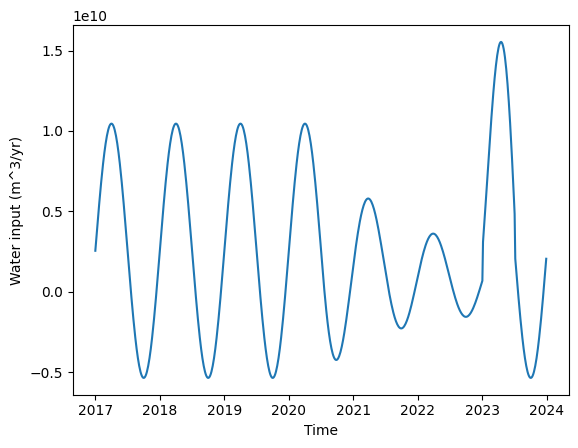

In [ ]:
# set up time-dependent values
# time step in years
dt = 0.01
time = np.arange(2017, 2024, dt)
# set up seasonal cycle in inputs plus drought
seasonal_cycle = 3.1
I = lta['I']*(1 + seasonal_cycle*np.sin(time*2*np.pi))

# set intervals of change in hydroclimate and water volume input
# add in drought
drought_begin = 2020.5
drought_end = 2023.0
recharge_end = 2023.5

# set drought rate
drought_decrease_per_year = seasonal_cycle*.35

#set post-drought recharge pulse
recharge_cycle = 1.8

# apply drought
I[(time > drought_begin) & (time < drought_end)] = I[(time > drought_begin) & (time < drought_end)]/(1 + drought_decrease_per_year*(time[(time > drought_begin) & (time < drought_end)] - drought_begin))

# end drought and recharge the lake volume
I[(time > drought_end) & (time < recharge_end)] = I[(time > drought_end) & (time < recharge_end)]*(1 + recharge_cycle*(time[(time > drought_end) & (time < recharge_end)] - drought_end))

# visualize drought on input
fig, ax = plt.subplots()
ax.plot(time,I)
ax.set_xlabel('Time')
ax.set_ylabel('Water input (m^3/yr)')

### Solving the differential equation

Now we integrate the diffeqs forward in time to see how a time-varying input affects lake volume, shoreline height, and the oxygen isotopic composition of the lake.

In [ ]:
# set up diff eqs
def dV_dt(I, E, A_l):
    dVdt = I - E*A_l
    return(dVdt)

def ddlake_dt(V, I, E, A_l, d_l, d_i, epsilon_e_l):
    ddlake_dt = (I*(d_i - d_l) - E*A_l*epsilon_e_l)/V
    return(ddlake_dt)

In [ ]:
# forward integrate for lake volume and lake d18O
# preallocate for V, Al, h, I, and d18O
gsl = {}
gsl['time'] = time
gsl['I'] = I
gsl['V'] = np.zeros(len(I))
gsl['V'][0] = lta['V']

gsl['d18O_l'] = np.zeros(len(I))
gsl['d18O_l'][0] = lta['d18O_l']
# step through time and run the model
for i in range(1,len(I)):
    last_V = gsl['V'][i-1]
    # Allow extrapolation by setting fill_value="extrapolate"
    last_Al = Al_from_V(last_V)
    last_I = I[i-1]
    # compute V
    new_V = last_V + dV_dt(last_I, lta['E'], last_Al)*dt
    gsl['V'][i] = new_V
    # compute d18O
    last_d18O_l = gsl['d18O_l'][i-1]
    new_d18O = last_d18O_l + ddlake_dt(last_V, last_I, lta['E'], last_Al, last_d18O_l, lta['d18O_i'], lta['epsilon_e-l'])*dt
    gsl['d18O_l'][i] = new_d18O

# compute h from V
# Allow extrapolation by setting fill_value="extrapolate"
gsl['h'] = h_from_V(gsl['V'])
# save output as an excel file for later use
# first, need to convert to df
gsl = pd.DataFrame(gsl)

# Convert the 'time' column to datetime objects and then format as MM/DD/YYYY
start_date = pd.to_datetime(int(gsl['time'].iloc[0]), format='%Y')
gsl['time'] = start_date + pd.to_timedelta((gsl['time'] - gsl['time'].iloc[0]) * 365.25, unit='D')
gsl['time'] = gsl['time'].dt.strftime('%m/%d/%Y')

gsl.to_excel('gsl_d18O_model_run_to2024.xlsx')



### Visualizing output

Some quick figures to visualize the output of the box model. First, load datasets that will be used.

In [ ]:
Saltair_lake_level = pd.read_csv("2017_2024_SaltairLevel.csv")
gsl_model_data = pd.read_excel("gsl_d18O_model_run_to2024.xlsx")
gsl_sample_data = pd.read_csv("CoreTop2-DICLWplot.csv")

Data type of gsl['time'] inside loop: datetime64[ns]
Data type of Saltair_lake_level['Date'] inside loop: datetime64[ns]


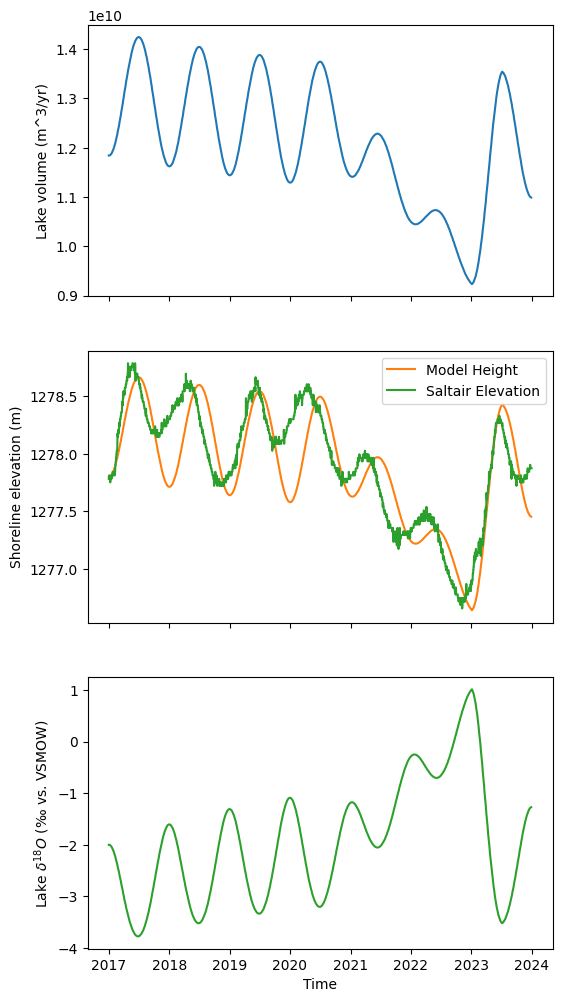

In [ ]:
# plot various things vs time
to_plot = ['V', 'h', 'd18O_l']
ax_labels = ['Lake volume (m^3/yr)', 'Shoreline elevation (m)', r'Lake $\delta^{18}O$ (‰ vs. VSMOW)']
ax_lab_dict = dict(zip(to_plot, ax_labels))
fig, axs = plt.subplots(nrows=len(to_plot), sharex=True, figsize=(6,12))

# Convert 'time' column in gsl to datetime objects if it's not already
if gsl['time'].dtype == 'object':
    gsl['time'] = pd.to_datetime(gsl['time'], format='%m/%d/%Y')

# Ensure Saltair_lake_level['Date'] is datetime objects
if Saltair_lake_level['Date'].dtype == 'object':
     Saltair_lake_level['Date'] = pd.to_datetime(Saltair_lake_level['Date'], format='%m/%d/%y')


for i, key in enumerate(to_plot):
    if key == 'h':
        # Check data types inside the loop before tz_localize
        print(f"Data type of gsl['time'] inside loop: {gsl['time'].dtype}")
        print(f"Data type of Saltair_lake_level['Date'] inside loop: {Saltair_lake_level['Date'].dtype}")

        # Ensure dates are timezone-naive before plotting
        gsl['time'] = gsl['time'].dt.tz_localize(None)
        Saltair_lake_level['Date'] = Saltair_lake_level['Date'].dt.tz_localize(None)

        axs[i].plot('time', key, '-',
                    data=gsl, color='C'+ str(i), label='Model Height')
        axs[i].plot(Saltair_lake_level['Date'], Saltair_lake_level['Elev_m'], '-', color='C'+ str(i+1), label='Saltair Elevation')
        axs[i].legend()
    else:
        axs[i].plot('time', key, '-',
                    data=gsl, color='C'+ str(i))
    axs[i].set_ylabel(ax_lab_dict[key])
axs[i].set_xlabel('Time')

fig.savefig('gsl_model_vs_time.pdf')

## Merge dataframes

We want to merge the model output including lake level and modeled lake water oxygen isotopic composition with the real-time lake level readings from a USGS monitoring site at Great Salt Lake.




1. Format date columns in dataframes to have the same format as MM/DD/YYYY.

In [ ]:
Saltair_lake_level['Date'] = pd.to_datetime(Saltair_lake_level['Date'], format='%m/%d/%y')
gsl_model_data['time'] = pd.to_datetime(gsl_model_data['time'], format='%m/%d/%Y')
gsl_sample_data['SamplingDate'] = pd.to_datetime(gsl_sample_data['SamplingDate'], format='%m/%d/%y')

2. Merge the Saltair lake level, GSL model, and sample data frames based on the date columns.


In [ ]:
# Select specific columns from gsl_sample_data and filter for non-null d18O_carb
sample_cols_to_include = ["SamplingDate", "Site", "carb_type", "Sample name", "d13C_carb", "d13C_carb_sd", "d18O_carb", "d18O_carb_sd", "d13C_DIC", "d13C_DIC_sd", "DIC_mM", "Ca", "Mg", "Cl", "SO4", "Temperature", "pH", "Alk.eq.kgw.", "omega_aragonite"]
gsl_sample_subset = gsl_sample_data[sample_cols_to_include].dropna(subset=['d18O_carb'])

# Merge gsl_model_data and filtered gsl_sample_data using an outer merge to include all rows from both
merged_gsl_data = pd.merge(gsl_model_data, gsl_sample_subset, left_on='time', right_on='SamplingDate', how='outer')

# Drop the redundant date column from gsl_sample_data
merged_gsl_data = merged_gsl_data.drop(columns=['SamplingDate'])

# Merge with Saltair_lake_level using a left merge to add elevation data
merged_gsl_data = pd.merge(merged_gsl_data, Saltair_lake_level[['Date', 'Elev_m']], left_on='time', right_on='Date', how='left')

# Drop the redundant date column from Saltair_lake_level
merged_gsl_data = merged_gsl_data.drop(columns=['Date'])

# Sort by time for chronological order
merged_gsl_data = merged_gsl_data.sort_values(by='time').reset_index(drop=True)



In [ ]:
# Filter gsl_sample_data for non-null 'd18O_carb' values
sample_with_d18O_carb = gsl_sample_data[gsl_sample_data['d18O_carb'].notna()]

# Extract unique 'SamplingDate' values from the filtered sample data
unique_sample_dates = sample_with_d18O_carb['SamplingDate'].unique()

# Extract unique 'time' values from the merged data
unique_merged_dates = merged_gsl_data['time'].unique()

# Find dates in unique_sample_dates that are not in unique_merged_dates
missing_dates = np.setdiff1d(unique_sample_dates, unique_merged_dates)

proximal_dates = {}
for missing_date_np in missing_dates:
    missing_date = pd.to_datetime(missing_date_np)
    time_diff = abs(gsl_model_data['time'] - missing_date)
    closest_index = np.argmin(time_diff)
    proximal_model_date = gsl_model_data['time'].iloc[closest_index]
    proximal_dates[missing_date] = proximal_model_date

# Create a list of the proximal model dates from the proximal_dates dictionary values.
proximal_model_dates_list = list(proximal_dates.values())

# Filter the gsl_model_data DataFrame to keep only the rows where the 'time' column is in the list of proximal model dates.
proximal_model_subset = gsl_model_data[gsl_model_data['time'].isin(proximal_model_dates_list)].copy()

# Create a new column with proximal model dates in sample_with_d18O_carb
sample_with_d18O_carb['proximal_model_date'] = sample_with_d18O_carb['SamplingDate'].map(proximal_dates)

# Select relevant columns from sample_with_d18O_carb
sample_cols_to_merge = ["SamplingDate", "Site", "carb_type", "Sample name", "d13C_carb", "d13C_carb_sd", "d18O_carb", "d18O_carb_sd", "d13C_DIC", "d13C_DIC_sd", "DIC_mM", "Ca", "Mg", "Cl", "SO4", "Temperature", "pH", "Alk.eq.kgw.", "omega_aragonite", "proximal_model_date"]
sample_subset_for_merge = sample_with_d18O_carb[sample_cols_to_merge]

# Merge with the proximal_model_subset
merged_proximal_data = pd.merge(proximal_model_subset, sample_subset_for_merge, left_on='time', right_on='proximal_model_date', how='left')

# Drop the redundant proximal_model_date column
merged_proximal_data = merged_proximal_data.drop(columns=['proximal_model_date'])

merged_gsl_data = pd.concat([merged_gsl_data, merged_proximal_data], ignore_index=True)
merged_gsl_data = merged_gsl_data.sort_values(by='time').drop_duplicates().reset_index(drop=True)

In [ ]:
# Ensure Saltair_lake_level 'Date' is datetime and set as index for easier lookup
Saltair_elev_series = Saltair_lake_level.set_index('Date')['Elev_m'].sort_index()

# Identify rows in merged_gsl_data where Elev_m is missing AND time is not NaT
missing_elev_and_valid_time_mask = merged_gsl_data['Elev_m'].isna() & merged_gsl_data['time'].notna()

# For rows with missing Elev_m and valid time, find the index (date) in Saltair_elev_series that is closest in time
# Use reindex with method='nearest' to find the nearest date and get its index
nearest_elev_dates = Saltair_elev_series.reindex(merged_gsl_data.loc[missing_elev_and_valid_time_mask, 'time'], method='nearest').index

# Get the Elev_m values corresponding to the nearest dates from Saltair_elev_series
nearest_elev_values = Saltair_elev_series.loc[nearest_elev_dates].values

# Fill the missing Elev_m values in merged_gsl_data for the filtered rows
merged_gsl_data.loc[missing_elev_and_valid_time_mask, 'Elev_m'] = nearest_elev_values


In [ ]:
# Save merged data
merged_gsl_data.to_excel('gsl_d18O_model_with_saltair.xlsx', index=False)

## Calculate the predicted oxygen isotopic compositions of carbonate formed in equilibrium with the evolving lake water composition.

We first need to convert the lakewater oxygen isotopic compositions from the VSMOW scale to the VPDB scale. We then will calculate the water-carbonate fractionation factor at chosen temperatures. We chose 15°C and 30°C based on the measured summer to fall temperatures in the 2019-20 year. Finally, we will calculate the equilibrium d18Oc values relative to VPDB at the two temperatures.

### Convert δ18o_l vs VSMOW to vs VPDB.

Convert the `d18O_l` values in the `merged_gsl_data` DataFrame reported relative to VSMOW to the VPDB reference frame using the equation from Coplen et al. (1983).

In [ ]:
merged_gsl_data['d18O_l_VPDB'] = (merged_gsl_data['d18O_l'] - 30.91) / 1.03091

### Calculate carbonate-water fractionation factors.

Define the two temperatures in Kelvin (288.15 K and 303.15 K) and then calculate the temperature-dependent fractionation factor (alpha) for each temperature.


In [ ]:
import math

temperatures_K = [288.15, 303.15]
alpha_values = {}
for temp_K in temperatures_K:
    alpha = math.exp(((17880/temp_K)-31.14)/1000 )
    alpha_values[temp_K] = alpha

### Calculate δ18O_c values of the carbonate minerals formed in equilibrium with the lake water at the defined temperatures.



In [ ]:
for temp_K in temperatures_K:
    alpha = alpha_values[temp_K]
    col_name = f'd18O_c_{int(temp_K)}K'
    merged_gsl_data[col_name] = (merged_gsl_data['d18O_l_VPDB'] + 1000) * alpha - 1000

### Add results to dataframe


Add the calculated `d18O_l_VPDB` and the three `d18O_c` columns (one for each temperature) to the `merged_gsl_data` DataFrame.


In [ ]:
# Save merged data
merged_gsl_data.to_excel('gsl_d18O_model_with_saltair.xlsx', index=False)

## Plot the modeled versus the measured δ18Ocarb.


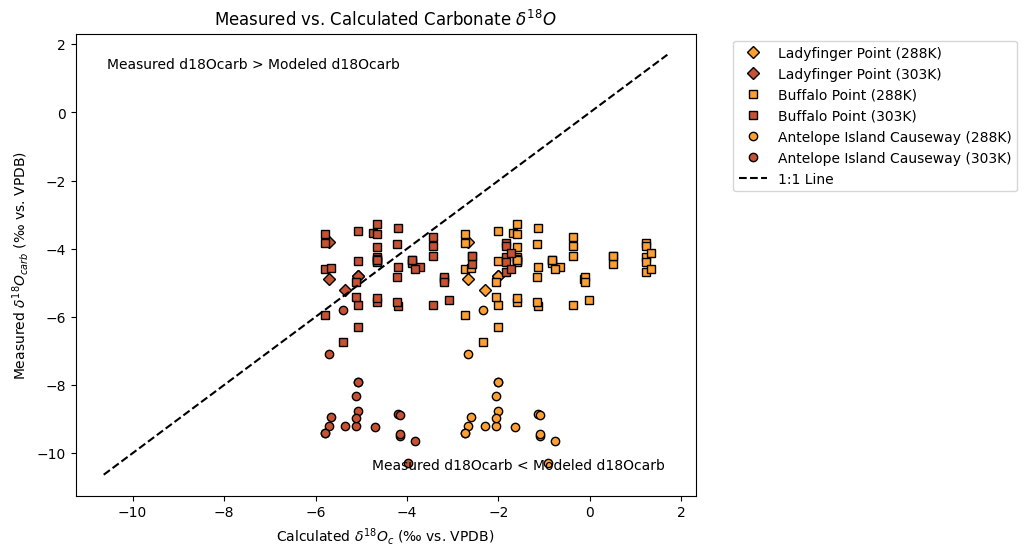

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6)) # Increased figure width

# Drop rows with NaN in 'd18O_carb' before plotting
plot_data = merged_gsl_data.dropna(subset=['d18O_carb'])

# Define markers for each site
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}

# Define colors for each temperature
temp_colors = {288: '#fd9f32', 303: '#c75233'}


# Plot measured d18O_carb data with different markers for each site and colors by temperature
for site, marker in site_markers.items():
    subset = plot_data[plot_data['Site'] == site]
    if not subset.empty:
        ax.plot(subset['d18O_c_288K'], subset['d18O_carb'], marker=marker, linestyle='', color=temp_colors[288], label=f'{site} (288K)', markeredgecolor='k')
        ax.plot(subset['d18O_c_303K'], subset['d18O_carb'], marker=marker, linestyle='', color=temp_colors[303], label=f'{site} (303K)', markeredgecolor='k')

# Add a 1:1 line
# Determine the range of the data for the 1:1 line
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# Add text labels
ax.text(0.05, 0.95, "Measured d18Ocarb > Modeled d18Ocarb", transform=ax.transAxes, ha='left', va='top')
ax.text(0.95, 0.05, "Measured d18Ocarb < Modeled d18Ocarb", transform=ax.transAxes, ha='right', va='bottom')

ax.set_xlabel(r'Calculated $\delta^{18}O_{c}$ (‰ vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.title(r'Measured vs. Calculated Carbonate $\delta^{18}O$')
plt.show()

fig.savefig('measured_vs_modeled_d18Ocarb.pdf', bbox_inches='tight') # Use bbox_inches='tight' to prevent legend cutoff

## Plot modeled and actual height data


In [ ]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
axs[0].plot(merged_gsl_data['time'], merged_gsl_data['h'], label='Model Lake Elevation')
axs[0].plot(merged_gsl_data['time'], merged_gsl_data['Elev_m'], label='Measured Elevation at Saltair')
axs[0].legend()
axs[0].set_ylabel('Shoreline elevation (m)')

Text(4.444444444444452, 0.5, 'Shoreline elevation (m)')

## Plot modeled lake oxygen isotope data



In [ ]:
axs[1].plot(merged_gsl_data['time'], merged_gsl_data['d18O_l'], label=r'Lake $\delta^{18}O$')
axs[1].set_ylabel(r'Lake $\delta^{18}O$ (‰ vs. VSMOW)')

Text(4.444444444444452, 0.5, 'Lake $\\delta^{18}O$ (‰ vs. VSMOW)')

# Plot carbonate oxygen isotope data, measured and modeled.

## Calculate Average d18Ocarb per Facies

Group the `merged_gsl_data` DataFrame by the 'carb_type' and 'Site' columns and calculate the mean of the 'd18O_carb' for each group. This will provide the average measured oxygen isotopic composition for each carbonate facies.


In [ ]:
average_d18O_carb_per_facies = merged_gsl_data.groupby(['carb_type', 'Site'])['d18O_carb'].mean()
print("Average d18Ocarb per facies grouped by carb_type and Site:")
print(average_d18O_carb_per_facies)

Average d18Ocarb per facies grouped by carb_type and Site:
carb_type                  Site                    
bulk microbial boundstone  Buffalo Point              -4.440000
                           Ladyfinger Point           -4.728571
bulk mud                   Antelope Island Causeway   -8.730000
crust                      Antelope Island Causeway   -8.791765
                           Buffalo Point              -5.425000
grain coating              Buffalo Point              -4.600000
white intraclast           Buffalo Point              -3.910714
Name: d18O_carb, dtype: float64


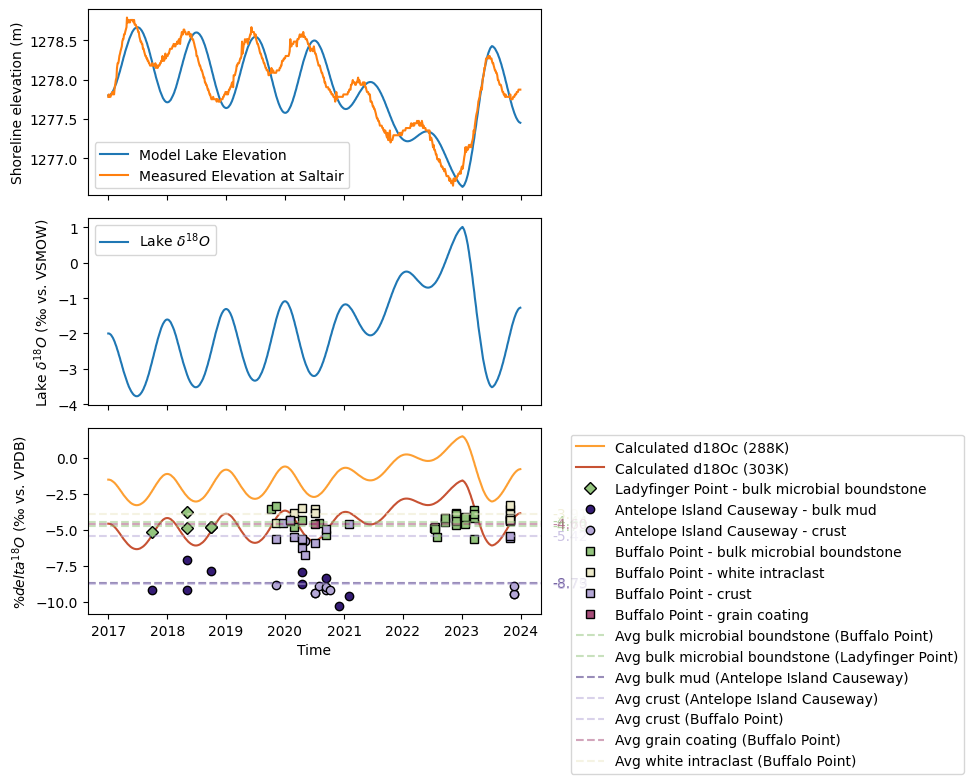

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define markers and colors for sample data based on 'Site' and 'carb_type'
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

# Assuming `merged_gsl_data` and `average_d18O_carb_per_facies` are already defined and in the kernel state

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

# --- Plot 1: Model H and Measured Elevation ---
axs[0].plot(merged_gsl_data['time'], merged_gsl_data['h'], label='Model Lake Elevation')
axs[0].plot(merged_gsl_data['time'], merged_gsl_data['Elev_m'], label='Measured Elevation at Saltair')
axs[0].set_ylabel('Shoreline elevation (m)')

# --- Plot 2: Model Lake d18O ---
axs[1].plot(merged_gsl_data['time'], merged_gsl_data['d18O_l'], label=r'Lake $\delta^{18}O$')
axs[1].set_ylabel(r'Lake $\delta^{18}O$ (‰ vs. VSMOW)')

# --- Plot 3: Carbonate oxygen isotope data, measured and modeled ---
# Plot calculated d18Oc data for different temperatures
axs[2].plot(merged_gsl_data['time'], merged_gsl_data['d18O_c_288K'], color='#fd9f32', label='Calculated d18Oc (288K)')
axs[2].plot(merged_gsl_data['time'], merged_gsl_data['d18O_c_303K'], color='#c75233', label='Calculated d18Oc (303K)')

# Plot measured d18O_carb data
for site in merged_gsl_data['Site'].unique():
    for carb_type in merged_gsl_data['carb_type'].unique():
        subset = merged_gsl_data[(merged_gsl_data['Site'] == site) & (merged_gsl_data['carb_type'] == carb_type)].dropna(subset=['d18O_carb'])
        if not subset.empty:
            axs[2].plot(subset['time'], subset['d18O_carb'],
                        marker=site_markers.get(site, 'x'), # Default to x if site not in dict
                        color=carb_colors.get(carb_type, 'black'), # Default to black if carb_type not in dict
                        linestyle='',
                        label=f'{site} - {carb_type}',
                        markeredgecolor='k') # Add black outline

# Add horizontal lines for average d18O_carb per facies
for (carb_type_str, site_str), avg_d18o in average_d18O_carb_per_facies.items(): # Unpack the tuple
    color = carb_colors.get(carb_type_str, 'gray') # Use carb_type_str for color
    axs[2].axhline(y=avg_d18o, color=color, linestyle='--', alpha=0.5, label=f'Avg {carb_type_str} ({site_str})') # Include site_str in label
    axs[2].annotate(f'{avg_d18o:.2f}', xy=(1, avg_d18o), xytext=(8, 0), xycoords=('axes fraction', 'data'),
                    textcoords='offset points', ha='left', va='center', color=color, alpha=0.7)

axs[2].set_ylabel(r'$\%delta^{18}O$ (‰ vs. VPDB)')
axs[2].set_xlabel('Time')

# Adjust legends for all subplots
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper left')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
plt.show()

fig.savefig('gsl_d18O_model_with_data_and_avg_facies.pdf')

In [ ]:
from itertools import combinations
from scipy import stats
import pandas as pd

# Get unique groups
unique_groups = gsl_filtered_for_stats['Group'].unique()

# Prepare to store p-values
p_values_list = []

# Perform pairwise t-tests
for group1, group2 in combinations(unique_groups, 2):
    data1 = gsl_filtered_for_stats[gsl_filtered_for_stats['Group'] == group1]['d18O_carb']
    data2 = gsl_filtered_for_stats[gsl_filtered_for_stats['Group'] == group2]['d18O_carb']

    # Only perform t-test if both groups have enough data points (at least 2)
    if len(data1) > 1 and len(data2) > 1:
        t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False) # Welch's t-test assuming unequal variances
        p_values_list.append({'group1': group1, 'group2': group2, 'p_value': p_val})

# Convert list of p-values to a DataFrame
p_values_df = pd.DataFrame(p_values_list)

print("Pairwise t-test p-values:")
print(p_values_df.to_string())

Pairwise t-test p-values:
                                          group1                                     group2       p_value
0   bulk microbial boundstone - Ladyfinger Point        bulk mud - Antelope Island Causeway  2.421891e-12
1   bulk microbial boundstone - Ladyfinger Point  bulk microbial boundstone - Buffalo Point  1.474142e-01
2   bulk microbial boundstone - Ladyfinger Point           white intraclast - Buffalo Point  1.515128e-03
3   bulk microbial boundstone - Ladyfinger Point                      crust - Buffalo Point  8.814913e-03
4   bulk microbial boundstone - Ladyfinger Point           crust - Antelope Island Causeway  1.609687e-11
5   bulk microbial boundstone - Ladyfinger Point              grain coating - Buffalo Point  4.637498e-01
6            bulk mud - Antelope Island Causeway  bulk microbial boundstone - Buffalo Point  8.799298e-14
7            bulk mud - Antelope Island Causeway           white intraclast - Buffalo Point  1.035114e-15
8            bulk mu

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


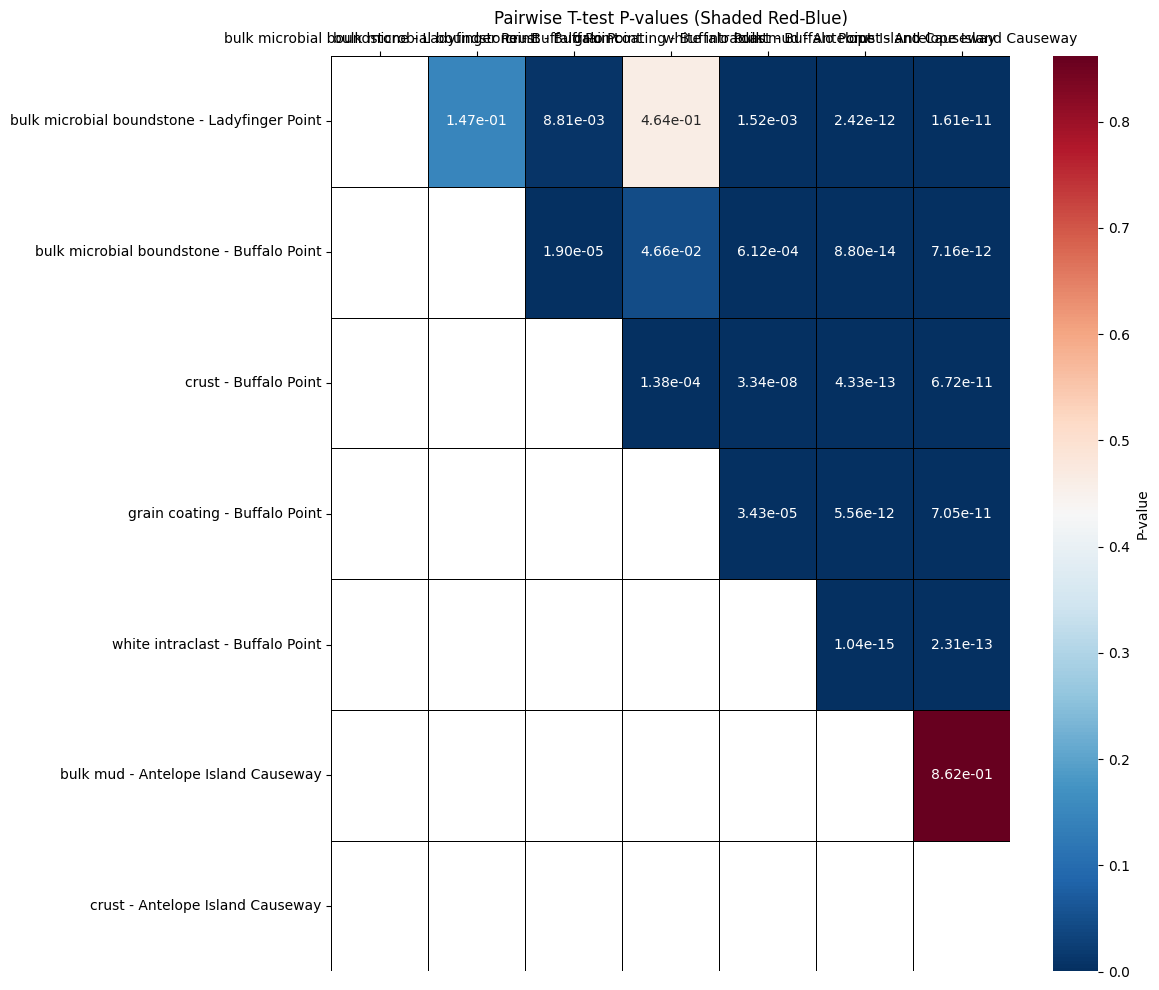

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get all unique group names (already available from previous execution)
all_groups = gsl_filtered_for_stats['Group'].unique()

# Define the desired order of groups
# Prioritize Ladyfinger Point, then Buffalo Point, then Antelope Island Causeway
ordered_groups = [
    'bulk microbial boundstone - Ladyfinger Point',
    'bulk microbial boundstone - Buffalo Point',
    'crust - Buffalo Point',
    'grain coating - Buffalo Point',
    'white intraclast - Buffalo Point',
    'bulk mud - Antelope Island Causeway',
    'crust - Antelope Island Causeway'
]

# Ensure all groups from all_groups are present in ordered_groups
# This handles cases where a group might be missed or new ones appear
# (though for this specific task, the manual list should cover it)
remaining_groups = [g for g in all_groups if g not in ordered_groups]
ordered_groups.extend(sorted(remaining_groups)) # Add any missing groups, sorted for consistency

# Create an empty DataFrame for the p-value matrix
p_value_matrix = pd.DataFrame(np.nan, index=all_groups, columns=all_groups)

# Populate the p-value matrix from the p_values_df
for _, row in p_values_df.iterrows():
    group1 = row['group1']
    group2 = row['group2']
    p_value = row['p_value']
    p_value_matrix.loc[group1, group2] = p_value
    p_value_matrix.loc[group2, group1] = p_value # t-test is symmetric

# Reindex the matrix to the desired order
p_value_matrix_reordered = p_value_matrix.reindex(index=ordered_groups, columns=ordered_groups)

# --- New: Make the matrix triangular (e.g., upper triangle only, excluding diagonal) ---
for i in range(len(ordered_groups)):
    for j in range(len(ordered_groups)):
        if j <= i: # Set lower triangle and diagonal to NaN
            p_value_matrix_reordered.iloc[i, j] = np.nan

# --- New: Create custom annotation DataFrame for bolding significant values ---
annot_matrix = p_value_matrix_reordered.copy().astype(str) # Initialize with string NaNs
for i in range(len(ordered_groups)):
    for j in range(len(ordered_groups)):
        p_val = p_value_matrix_reordered.iloc[i, j]
        if not pd.isna(p_val):
            # Changed format to '.2e' for scientific notation with two decimal places
            formatted_p_val = f"{p_val:.2e}"
            if p_val < 0.05:
                annot_matrix.iloc[i, j] = f"{formatted_p_val}"
            else:
                annot_matrix.iloc[i, j] = formatted_p_val
        else:
            annot_matrix.iloc[i, j] = "" # Empty string for NaN cells

plt.figure(figsize=(12, 10))
ax = sns.heatmap(p_value_matrix_reordered, annot=annot_matrix, fmt="", cmap='RdBu_r', # fmt="" because annot is already formatted string
            cbar_kws={'label': 'P-value'}, linewidths=.5, linecolor='black')
plt.title('Pairwise T-test P-values (Shaded Red-Blue)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Move x-axis labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('pairwise_t_test_p_values_heatmap_reordered_triangular_bold.pdf') # Save before showing
plt.show()
